In [2]:
from typing import Tuple, Sequence, Dict, Union, Optional
import numpy as np
import math
import torch
import torch.nn as nn
import collections
from diffusers.schedulers.scheduling_ddpm import DDPMScheduler
from diffusers.training_utils import EMAModel
from diffusers.optimization import get_scheduler
from tqdm.auto import tqdm
from torch.utils.data import Dataset, DataLoader
import os
from pathlib import Path

from diffusion_data_loader import DiffusionPolicyDataset
from diffusion_network import *
import matplotlib.pyplot as plt

In [3]:
trajectory_dir = "/Users/sarthakdas/Downloads/Ark/diffusion_policy/data_collection/trajectories"
model_path = "/Users/sarthakdas/Downloads/Ark/diffusion_policy/training/models/ema_noise_pred_net_epoch_210.pth"

In [4]:
# horizons (same convention as Push‑T example)
pred_horizon   = 16  # p
obs_horizon    = 8   # o
action_horizon = 8   # a
subsample: int = 2

batch_size = 1

obs_dim = 10
action_dim = 8
num_diffusion_iters = 100
#|o|o|                             observations: 2
#| |a|a|a|a|a|a|a|a|               actions executed: 8
#|p|p|p|p|p|p|p|p|p|p|p|p|p|p|p|p| actions predicted: 16

In [5]:
# load the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
state_dict = torch.load(model_path, map_location=device)

# create network object
noise_pred_net = ConditionalUnet1D(
    input_dim=action_dim,
    global_cond_dim=obs_dim*obs_horizon
)

ema = EMAModel(
    parameters=noise_pred_net.parameters(),
    power=0.75
)

# for this demo, we use DDPMScheduler with 100 diffusion iterations

noise_scheduler = DDPMScheduler(
    num_train_timesteps=num_diffusion_iters,
    # the choise of beta schedule has big impact on performance
    # we found squared cosine works the best
    beta_schedule='squaredcos_cap_v2',
    # clip output to [-1,1] to improve stability
    clip_sample=True,
    # our network predicts noise (instead of denoised action)
    prediction_type='epsilon'
)

ema_noise_pred_net = noise_pred_net
ema_noise_pred_net.load_state_dict(state_dict)

# add a check to ensure the model is in eval mode
ema_noise_pred_net.eval()


number of parameters: 6.636750e+07


ConditionalUnet1D(
  (mid_modules): ModuleList(
    (0-1): 2 x ConditionalResidualBlock1D(
      (blocks): ModuleList(
        (0-1): 2 x Conv1dBlock(
          (block): Sequential(
            (0): Conv1d(1024, 1024, kernel_size=(5,), stride=(1,), padding=(2,))
            (1): GroupNorm(8, 1024, eps=1e-05, affine=True)
            (2): Mish()
          )
        )
      )
      (cond_encoder): Sequential(
        (0): Mish()
        (1): Linear(in_features=336, out_features=2048, bias=True)
        (2): Unflatten(dim=-1, unflattened_size=(-1, 1))
      )
      (residual_conv): Identity()
    )
  )
  (diffusion_step_encoder): Sequential(
    (0): SinusoidalPosEmb()
    (1): Linear(in_features=256, out_features=1024, bias=True)
    (2): Mish()
    (3): Linear(in_features=1024, out_features=256, bias=True)
  )
  (up_modules): ModuleList(
    (0): ModuleList(
      (0): ConditionalResidualBlock1D(
        (blocks): ModuleList(
          (0): Conv1dBlock(
            (block): Sequential(


In [6]:
# ── Dataset & loader ────────────────────────────────────────────────────
dataset = DiffusionPolicyDataset(
    dataset_path=str(trajectory_dir),
    pred_horizon=pred_horizon,
    obs_horizon=obs_horizon,
    action_horizon=action_horizon,
    subsample=subsample,
)

dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=1,
    pin_memory=True,
)

In [8]:
def inference(nobs, noise_scheduler: DDPMScheduler, num_diffusion_iters: int = 100):
    nobs = nobs.to(device, dtype=torch.float32)
    B = 1
    with torch.no_grad():
            # reshape observation to (B,obs_horizon*obs_dim)
            obs_cond = nobs.unsqueeze(0).flatten(start_dim=1)

            # initialize action from Guassian noise
            print(pred_horizon, action_dim)
            noisy_action = torch.randn(
                (B, pred_horizon, action_dim), device=device)
            # send to cpu
            naction = noisy_action.to('cpu')
            obs_cond = obs_cond.to('cpu')

            # init scheduler
            noise_scheduler.set_timesteps(num_diffusion_iters)

            for k in noise_scheduler.timesteps:
                # predict noise
                naction
            
                noise_pred = ema_noise_pred_net(
                    sample=naction,
                    timestep=k,
                    global_cond=obs_cond
                )

                # inverse diffusion step (remove noise)
                naction = noise_scheduler.step(
                    model_output=noise_pred,
                    timestep=k,
                    sample=naction
                ).prev_sample

    naction = naction.detach().to('cpu').numpy()
    # (B, pred_horizon, action_dim)
    naction = naction[0]
    return naction

torch.Size([1, 8, 10])
16 8
(16, 8)


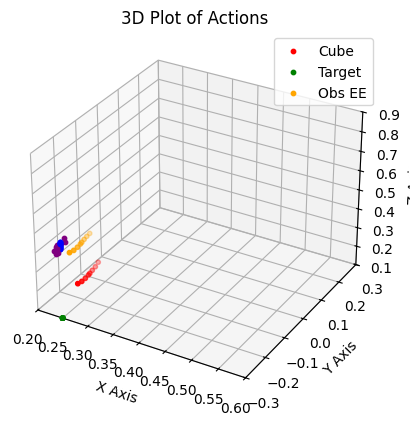

In [10]:
def plot_many_samples(batch, action):
    # extract observations from batch 0
    obs = batch['obs'][0]
    # extract the x,y,z coordinates
    cube_x_obs = obs[:, 0]
    cube_y_obs = obs[:, 1]
    cube_z_obs = obs[:, 2]

    # extract target observations from batch 0
    target_x_obs = obs[:, 3]
    target_y_obs = obs[:, 4]
    target_z_obs = obs[:, 5]

    obs_x = obs[:, 7]
    obs_y = obs[:, 8]
    obs_z = obs[:, 9]

    # extract actions from batch 0
    actions = batch['action'][0]
    
    # extract the x,y,z,
    x = actions[:, 0]
    y = actions[:, 1]
    z = actions[:, 2]

    gripper = actions[:, 7]


    action_x = action[:, 0]
    action_y = action[:, 1]
    action_z = action[:, 2]
    action_gripper = action[:, 7]

    # plot the actions 3D graph
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # print out cube pos to 2 dp
    # for i in range(len(cube_x_obs)):
        # print(f"Cube Position: ({cube_x_obs[i]:.2f}, {cube_y_obs[i]:.2f}, {cube_z_obs[i]:.2f})")
    
    
    # if gripper is 1 then plot x,y,z, as pink
    for i in range(len(gripper)):
        # print(gripper[i])
        if gripper[i] > 0.5:
            ax.scatter(x[i], y[i], z[i], color='pink', s=10)
        else:
            ax.scatter(x[i], y[i], z[i], color='blue', s=10)

    for i in range(len(action_gripper)):
        # print(action_gripper[i])
        if action_gripper[i] > 0.5:
            ax.scatter(action_x[i], action_y[i], action_z[i], color='orchid', s=10)
        else:
            ax.scatter(action_x[i], action_y[i], action_z[i], color='purple', s=10)


    
    # ax.scatter(x, y, z, color='blue', label='Actions', s=10)
    ax.scatter(cube_x_obs, cube_y_obs, cube_z_obs, color='red', label='Cube', s=10)
    ax.scatter(target_x_obs, target_y_obs, target_z_obs, color='green', label='Target', s=10)
    ax.scatter(obs_x, obs_y, obs_z, color='orange', label='Obs EE', s=10)
    # ax.scatter(action_x, action_y, action_z, color='purple', label='Predicted Actions', s=10)
    ax.set_xlabel('X Axis')
    ax.set_ylabel('Y Axis')
    ax.set_zlabel('Z Axis')
    ax.set_title('3D Plot of Actions')
    # fix the axis limits
    ax.set_xlim([0.2, 0.6])
    ax.set_ylim([-0.3, 0.3])
    ax.set_zlim([0.1, 0.9])
    ax.legend()
    plt.show()

batch = next(iter(dataloader))
print(batch['obs'].shape)
action = inference(batch['obs'], noise_scheduler=noise_scheduler, num_diffusion_iters=100)
print(action.shape)
plot_many_samples(batch, action)